<a id="id_0"></a>
# Analyse Model Performance
## Context
**Project Name:** Predict Netflix titles that Mum will watch        
**Written by:** Claudia Wallis         
**Created:** 27/02/2022           
**Last modifed:** 27/02/20212           

## Objective
**Analyse performance of Model built to identify Netflix titles that Mum will watch**           

## Input Data 
1. model_mum.pkl from 2.build_model.ipynb
2. train_mum.pkl from 2.build_model.ipynb
3. test_mum.pkl from 2.build_model.ipynb


## Table of Contents
1. [Set Up](#id_1)
    - 1a. Import packages
    - 1b. Update variables
2. [Load Data](#id_2)
    - 2a. Load data
    - 2b. Checks
3. [Score Data](#id_3)
    - 3a. Training set
    - 3b. Test set
4. [Analyse Decile Distribution](#id_4)
    - 4a. Training set
    - 4b. Test set
5. [Threshold Statistics](#id_5)

<a id="id_1"></a>
## 1. Set Up
#### 1a) Import packages

In [1]:
# base packages
import pandas as pd
import numpy as np

# etc
import time
import pickle
import os
import random
from random import sample
import math

# visualisation and data wrangling
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
from matplotlib.gridspec import GridSpec
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
import cufflinks as cf

# modeling
# from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss
from sklearn.metrics import auc, roc_auc_score, roc_curve, f1_score
from xgboost import XGBClassifier

# pipeline functions
os.chdir('C:\\Users\\claud\\Documents\\code\\')
import pipeline; import importlib; importlib.reload(pipeline)
from pipeline.fns import data_summary, hex_rgb, deciles, deciles_per_train
from pipeline.fns import decile_stats, decile_plot, psi_calc, opt_prob_threshold, threshold_based_metrics

# python related
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.filterwarnings("ignore")
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

#### 1b) Update Variables

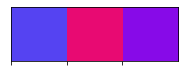

In [2]:
# update paths
path = 'C:\\Users\\claud\\Documents\\data\\'

# set seed 
seed = 24
random.seed(seed)

# set key colours
palette = ['#5543F2', '#E80A72', '#870AE8']
sns.set_palette(palette)
sns.palplot(sns.color_palette())
rgb_palette = hex_rgb(palette)

# plotting settings
cf.go_offline(connected = True)
init_notebook_mode(connected = True)
cf.set_config_file(world_readable = False, theme = 'pearl')
sns.set_style('dark')

# set options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows',None)
pd.set_option('float_format', '{:f}'.format)

<a id="id_2"></a>
## 2. Load Data
#### 2a) Load data

In [3]:
# load train & test
df_train = pd.read_pickle(path + 'output_data//train_mum.pkl')
df_test = pd.read_pickle(path + 'output_data//test_mum.pkl')

# load model
with open(path + 'model_mum_os.pkl', 'rb') as file:
    model = pickle.load(file)

#### 2b) Checks

In [4]:
# Checks
print('Train outcome rate = ' +
      str(round(df_train[df_train['Label'] == 1].shape[0]/df_train.shape[0] * 100, 3)) +
      '%')
display(df_train.shape)
display(data_summary(df_train, id_col = 'Title id', gb_col = 'Label'))

print('Test outcome rate = ' +
      str(round(df_test[df_test['Label'] == 1].shape[0]/df_test.shape[0] * 100, 3)) +
      '%')
display(df_test.shape)
display(data_summary(df_test, id_col = 'Title id', gb_col = 'Label'))

Train outcome rate = 6.107%


(2882, 109)

,Label,row_count,unique_id_count
0,0,2706,2706
1,1,176,176


Test outcome rate = 6.103%


(721, 109)

,Label,row_count,unique_id_count
0,0,677,677
1,1,44,44


<a id="id_3"></a>
## 3. Score Data
#### 3a) Training set

In [5]:
# drop excess columns
X_train = df_train.drop(['Label', 'Title id'], axis = 1)
df_train.reset_index(drop = True, inplace = True)

# get Model predictions
train_probs = model.predict_proba(X_train)
# predictions = model.predict(X_train)

# join probs onto df_train
df_train_preds = pd.DataFrame({'label_0_prob' : train_probs[:, 0], 'label_1_prob' : train_probs[:, 1]})
df_train_preds = df_train[['Title id', 'Label']].merge(df_train_preds, left_index = True, right_index = True)

In [6]:
# make predictions on validation set
X_train = X_train.values[:, :]
Y_train = df_train.values[:, 0]

train_predictions = model.predict(X_train)
train_probs_1 = []
for i in range(len(train_probs)):
    train_probs_1.append(train_probs[i][1])

print('Accuracy = ' + str(accuracy_score(Y_train, train_predictions)))
print('Log Loss = ' + str(log_loss(Y_train, train_probs)))
print('ROC-AUC = ' + str(roc_auc_score(Y_train, train_probs_1)))
print('Gini = ' + str(2 * roc_auc_score(Y_train, train_probs_1) - 1))
print(classification_report(Y_train, train_predictions))
display(pd.crosstab(Y_train, train_predictions, rownames = ['Actual'], colnames = ['Predicted'], margins = True))

fpr, tpr, thresholds = roc_curve(Y_train, train_probs_1)
roc_auc = auc(fpr, tpr)

df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
cf.set_config_file(dimensions = (800, 800), margin = (70, 70, 70, 70))
CI = [{'x0' : 0, 'y0' : 0, 'x1' : 1, 'y1' : 1, 'color' : 'black'}]
df.iplot(x = 'fpr', y = 'tpr', vline = CI, title = 'ROC Curve',
         xTitle = 'False Positive Rate', yTitle = 'True Positive Rate',
         colors = rgb_palette[0])

Accuracy = 0.9902845246356696
Log Loss = 0.030151391717686726
ROC-AUC = 0.9957879795740106
Gini = 0.9915759591480211
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      2706
         1.0       0.98      0.86      0.92       176

    accuracy                           0.99      2882
   macro avg       0.99      0.93      0.95      2882
weighted avg       0.99      0.99      0.99      2882



Predicted,0.0,1.0,All
Actual,,,
0.0,2703,3,2706
1.0,25,151,176
All,2728,154,2882


#### 3b) Test set
Clearly our Model has overfitted as our test results aren't as good as our train results

In [7]:
# drop excess columns
X_test = df_test.drop(['Label', 'Title id'], axis = 1)
df_test.reset_index(drop = True, inplace = True)

# get Model predictions
test_probs = model.predict_proba(X_test)

# join probs onto df_train
df_test_preds = pd.DataFrame({'label_0_prob' : test_probs[:, 0], 'label_1_prob' : test_probs[:, 1]})
df_test_preds = df_test[['Title id', 'Label']].merge(df_test_preds, left_index = True, right_index = True)

In [8]:
# make predictions on validation set
X_test = X_test.values[:, :]
Y_test = df_test.values[:, 0]

test_predictions = model.predict(X_test)
test_probs_1 = []
for i in range(len(test_probs)):
    test_probs_1.append(test_probs[i][1])

print('Accuracy = ' + str(accuracy_score(Y_test, test_predictions)))
print('Log Loss = ' + str(log_loss(Y_test, test_probs)))
print('ROC-AUC = ' + str(roc_auc_score(Y_test, test_probs_1)))
print('Gini = ' + str(2 * roc_auc_score(Y_test, test_probs_1) - 1))
print(classification_report(Y_test, test_predictions))
display(pd.crosstab(Y_test, test_predictions, rownames = ['Actual'], colnames = ['Predicted'], margins = True))

fpr, tpr, thresholds = roc_curve(Y_test, test_probs_1)
roc_auc = auc(fpr, tpr)

df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
cf.set_config_file(dimensions = (800, 800), margin = (70, 70, 70, 70))
CI = [{'x0' : 0, 'y0' : 0, 'x1' : 1, 'y1' : 1, 'color' : 'black'}]
df.iplot(x = 'fpr', y = 'tpr', vline = CI, title = 'ROC Curve',
         xTitle = 'False Positive Rate', yTitle = 'True Positive Rate',
         colors = rgb_palette[0])

Accuracy = 0.9348127600554785
Log Loss = 0.24777280062946738
ROC-AUC = 0.7625218208674633
Gini = 0.5250436417349267
              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97       677
         1.0       0.36      0.09      0.15        44

    accuracy                           0.93       721
   macro avg       0.65      0.54      0.56       721
weighted avg       0.91      0.93      0.92       721



Predicted,0.0,1.0,All
Actual,,,
0.0,670,7,677
1.0,40,4,44
All,710,11,721


<a id="id_4"></a>
## 4. Analyse Decile Distribution
#### 4a) Training set

In [9]:
df_train_preds = deciles(df_train_preds)
df_train_preds['decile'].describe()

count   2882.000000
mean       5.501388
std        2.873021
min        1.000000
25%        3.000000
50%        5.500000
75%        8.000000
max       10.000000
Name: decile, dtype: float64

In [10]:
db_train = decile_stats(df_train_preds)
display(db_train)

176(6.11%) entries are labelled 1
2706(93.89%) entries are labelled 0
There are 2882 entries in total
98.3% of outcomes in top 1 deciles

Score Delta = 0.97


,decile,min_score,max_score,avg_score,volume,outcome_volume,outcome_rate,actual_log_odds,predicted_log_odds,score_delta
0,1.000000,0.023551,0.992978,0.540025,288,173.000000,0.600694,0.408359,0.160444,0.247916
1,2.000000,0.009562,0.023493,0.014711,288,1.000000,0.003472,-5.659482,-4.204362,1.455120
2,3.000000,0.005671,0.009540,0.007248,288,1.000000,0.003472,-5.659482,-4.919775,0.739707
3,4.000000,0.003541,0.005664,0.004487,288,1.000000,0.003472,-5.659482,-5.401970,0.257512
4,5.000000,0.002158,0.003538,0.002793,289,0.000000,0.000000,-inf,-5.877887,inf
5,6.000000,0.001454,0.002145,0.001782,288,0.000000,0.000000,-inf,-6.328310,inf
6,7.000000,0.000934,0.001448,0.001195,288,0.000000,0.000000,-inf,-6.728444,inf
7,8.000000,0.000543,0.000933,0.000724,288,0.000000,0.000000,-inf,-7.230151,inf
8,9.000000,0.000288,0.000543,0.000415,288,0.000000,0.000000,-inf,-7.785991,inf
9,10.000000,0.000019,0.000288,0.000167,289,0.000000,0.000000,-inf,-8.694826,inf


<module 'matplotlib.pyplot' from 'C:\\Users\\claud\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

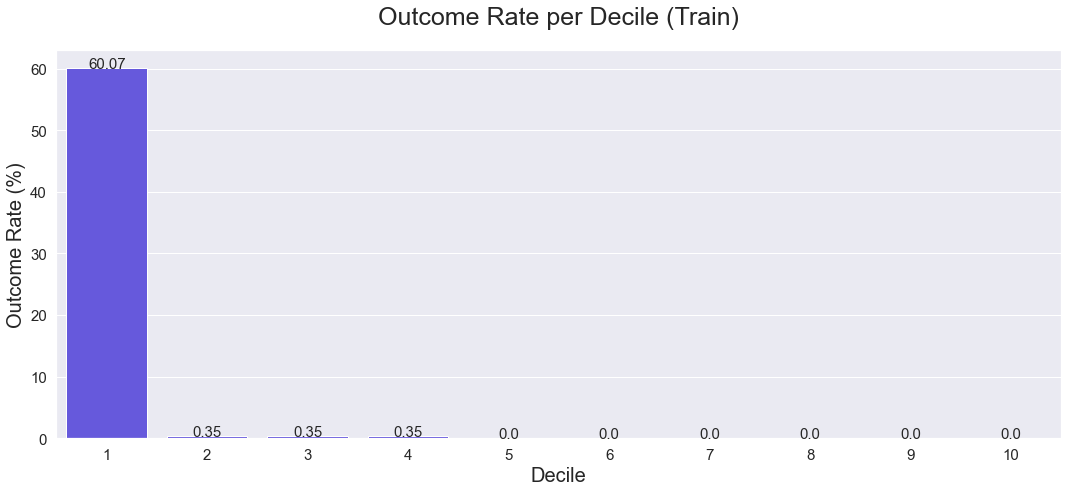

In [11]:
decile_plot(db_train, figsize_x = 15, figsize_y = 7, title_font_size = 25,
                axis_title_font_size = 20, tick_size = 15, title_gap = 1.05, bar_text_font_size = 15, colour = palette[0])

#### 4b) Test set

In [12]:
[df_test_preds_d, decile_bands_min_score] = deciles_per_train(df_test_preds, df_train_preds)
df_test_preds_d['decile'].describe()

,decile,min_score
0,1.000000,0.023551
288,2.000000,0.009562
576,3.000000,0.005671
864,4.000000,0.003541
1152,5.000000,0.002158
1441,6.000000,0.001454
1729,7.000000,0.000934
2017,8.000000,0.000543
2305,9.000000,0.000288
2593,10.000000,0.000019


count   721.000000
mean      4.932039
std       3.114855
min       1.000000
25%       2.000000
50%       5.000000
75%       8.000000
max      10.000000
Name: decile, dtype: float64

44(6.1%) entries are labelled 1
677(93.9%) entries are labelled 0
There are 721 entries in total
54.55% of outcomes in top 1 deciles

Score Delta = 3.02


,decile,min_score,max_score,avg_score,volume,outcome_volume,outcome_rate,actual_log_odds,predicted_log_odds,score_delta
0,1,0.023845,0.990122,0.161193,141,24.000000,0.170213,-1.584120,-1.649380,0.065260
1,2,0.009611,0.023549,0.015146,87,6.000000,0.068966,-2.602690,-4.174779,1.572090
2,3,0.005826,0.009333,0.007412,55,2.000000,0.036364,-3.277145,-4.897223,1.620078
3,4,0.003576,0.005611,0.004456,68,4.000000,0.058824,-2.772589,-5.409080,2.636491
4,5,0.002169,0.003512,0.002755,74,3.000000,0.040541,-3.164068,-5.891428,2.727360
5,6,0.001462,0.002144,0.001792,50,0.000000,0.000000,-inf,-6.322689,inf
6,7,0.000935,0.001454,0.001189,43,1.000000,0.023256,-3.737670,-6.733085,2.995416
7,8,0.000547,0.000931,0.000743,69,3.000000,0.043478,-3.091042,-7.204482,4.113439
8,9,0.000290,0.000541,0.000413,59,1.000000,0.016949,-4.060443,-7.792466,3.732023
9,10,0.000032,0.000274,0.000164,75,0.000000,0.000000,-inf,-8.717370,inf


<module 'matplotlib.pyplot' from 'C:\\Users\\claud\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

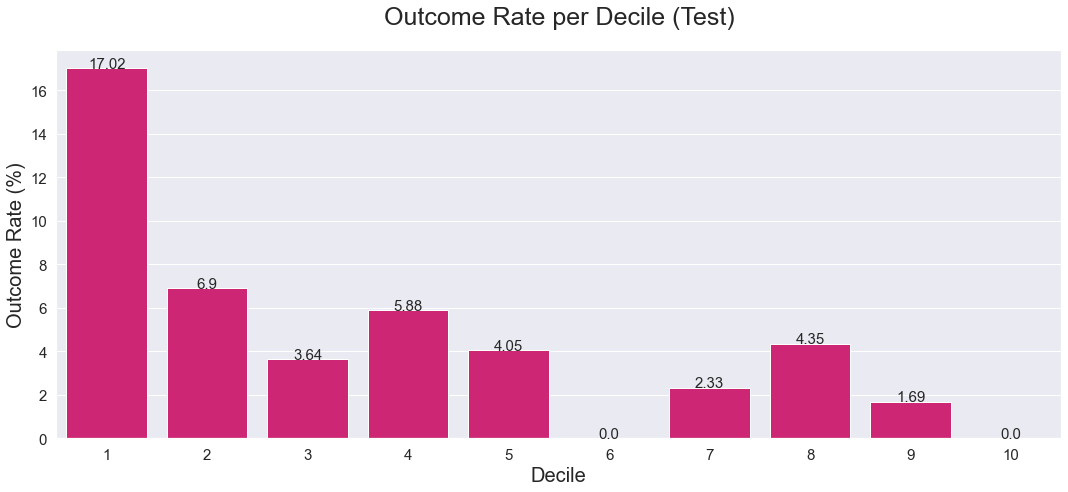

In [13]:
db_test = decile_stats(df_test_preds, decile_cut_off = 1)
display(db_test)
decile_plot(db_test, title = 'Outcome Rate per Decile (Test)', figsize_x = 15, figsize_y = 7, title_font_size = 25,
            axis_title_font_size = 20, tick_size = 15, title_gap = 1.05, bar_text_font_size = 15, colour = palette[1])

In [14]:
psi_df = psi_calc(db_train, db_test)[0]
psi_df

Overall test PSI = 0.1108


,decile,volume_train,train_percent,volume_test,test_percent,psi
0,1.000000,288,9.993000,141,19.556000,0.064210
1,2.000000,288,9.993000,87,12.067000,0.003910
2,3.000000,288,9.993000,55,7.628000,0.006390
3,4.000000,288,9.993000,68,9.431000,0.000330
4,5.000000,289,10.028000,74,10.264000,0.000050
5,6.000000,288,9.993000,50,6.935000,0.011170
6,7.000000,288,9.993000,43,5.964000,0.020800
7,8.000000,288,9.993000,69,9.570000,0.000180
8,9.000000,288,9.993000,59,8.183000,0.003620
9,10.000000,289,10.028000,75,10.402000,0.000140


<a id="id_5"></a>
## 5. Threshold Statistics

In [15]:
[threshold_df, opt_threshold] = opt_prob_threshold(test_probs, Y_test, metric = 'f1', colour = rgb_palette[2])

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       677
           1       0.35      0.27      0.31        44

    accuracy                           0.93       721
   macro avg       0.65      0.62      0.63       721
weighted avg       0.92      0.93      0.92       721

True positive rate (sensitivity/recall) = 1.8%
False positive rate = 3.25%
Precision = 35.29%
False discovery rate = 64.71%
False negative rate = 72.73%
True negative rate = 96.75%


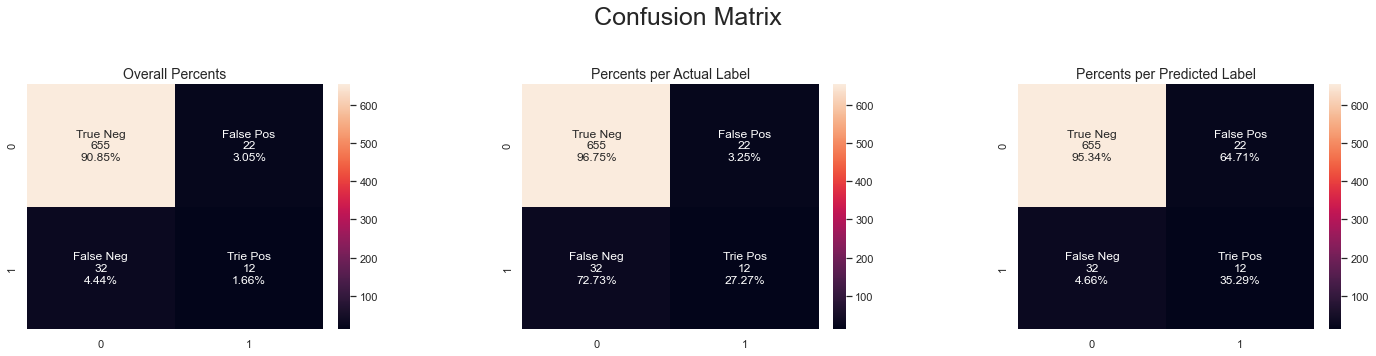

In [16]:
cm = threshold_based_metrics(df_test_preds, actual_label_col = 'Label', threshold = opt_threshold, score_col = 'label_1_prob')

[Back to top](#id_0)